In [ ]:
import dask.dataframe as dd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from joblib import Parallel, delayed
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap
parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesBacteriaPhage/PhasePortraitResourcesBacteriaPhage.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesBacteriaPhage/PhasePortraitResourcesBacteriaPhage.pickle'

In [2]:
def analyze_matrix(pickle_data):
    matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    def process_resource(i, resource_value):
        print("querying on resource=", resource_value)
        ddf = dd.read_parquet(
            parquet_file_path,
            engine='pyarrow',
            include_partition_columns=True,
            gather_statistics=True,
            dtype_backend='pyarrow',
            filters=[("Resources", "==", str(resource_value))]
        )
        ddf = ddf.rename(columns={'Uninfected Bacteria': 'Uninfected_Bacteria'})
        local_matrix = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        local_matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        for j, bacteria_value in enumerate(pickle_data['param_values_list_combination'][1]):
            for k, phage_value in enumerate(pickle_data['param_values_list_combination'][2]):
                simulation_results = ddf.query(f"Phages == {phage_value} and Uninfected_Bacteria == {bacteria_value}").compute()
                y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
                if np.any(y_values > phage_value * 2):
                    local_matrix[j, k] = np.max(y_values)
                    local_matrix2[j, k] = 1
        return local_matrix, local_matrix2

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, (col, col2) in enumerate(results):
        matrix[i, :, :] = col
        matrix2[i, :, :] = col2
    return matrix, matrix2

In [15]:
from tkinter import font


def create_plot(x_dim, y_dim, z_dim, matrix, pickle_data, save_fig=None):
    fig = plt.figure(figsize=(8, 6))
    voxels = np.zeros((x_dim, y_dim, z_dim), dtype=bool)
    print(x_dim, y_dim, z_dim)
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if matrix[i, j, k] > 0:
                    voxels[i, j, k] = matrix[i, j, k]
    # Normalize matrix values for color mapping (0 = white, max = red)
    norm = Normalize(vmin=matrix.min(), vmax=matrix.max())
    norm_matrix = norm(matrix)
    colors = np.ones(voxels.shape + (4,), dtype=float)
    colors[..., 0] = 1  # Red channel
    colors[..., 1] =  1 - norm_matrix  # Green channel decreases with value
    colors[..., 2] = 1 - norm_matrix  # Blue channel decreases with value
    colors[..., 3] = voxels.astype(float)  # Alpha channel: only show where voxels is True
    fig = plt.figure(figsize=(18, 18))
    views = [
    # (30, -60), 
    # (30, -120), 
    # (30, 60), 
    # (30, 120), 
    (-30, -60),
    (-30, -120), 
    # (-30, 60),
    # (-30, 120), 
]
    xtick_indices = np.arange(0, x_dim, 5)
    xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
    ytick_indices = np.arange(0, y_dim, 5)
    ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
    ztick_indices = np.arange(0, z_dim, 5)
    ztick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][2])[ztick_indices]]

    for idx, (elev, azim) in enumerate(views):
        ax = fig.add_subplot(1, 2, idx + 1, projection='3d')
        ax.voxels(voxels, facecolors=colors, edgecolor='k', linewidth=0.5)
        ax.set_xlabel('Resources', fontsize=16)
        ax.set_ylabel('Bacteria', fontsize=16)
        ax.set_zlabel('Phages', fontsize=16)
        ax.set_xticks(xtick_indices)
        ax.set_xticklabels(xtick_labels, fontsize=10)
        ax.set_yticks(ytick_indices)
        ax.set_yticklabels(ytick_labels, fontsize=10)
        ax.set_zticks(ztick_indices)
        ax.set_zticklabels(ztick_labels, fontsize=10)
        ax.view_init(elev=elev, azim=azim)
        # Add colorbar for the normalized matrix values
    white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
    sm = ScalarMappable(cmap=white_red, norm=norm)
    sm.set_array([])  # Needed for colorbar

    # Add colorbar to figure
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Max Phage Value Reached", rotation=270, labelpad=15, fontsize=16)
    plt.suptitle('Boundary of Phage Proliferation for Different Initial Resources, \nUninfected Bacteria, and Phages', fontsize=20)
    # plt.tight_layout()
    if save_fig is not None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')
    plt.show()

parameter_names_used ['Resources', 'Uninfected Bacteria', 'Phages']
param_values_list_combination [[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0], [40.0, 40.51282051282051, 41.02564102564102, 41.53846153846154, 42.05128205128205, 42.56410256410256, 43.07692307692308, 43.58974358974359, 44.1025641025641, 44.61538461538461, 45.128205128205124, 45.64102564102564, 46.15384615384615, 46.666666666666664, 47.17948717948718, 47.69230769230769, 48.205128205128204, 48.717948717948715, 49.230769230769226, 49.743589743589745, 50.256410256410255, 50.76923076923077, 51.282051282051285, 51.794871794871796, 52.30769230769231, 52.82051282051282, 53.33333333333333, 53.84615384615385, 54.35897435897436, 54.87179487179487, 55.38461538461539, 55.8974358974359, 56.41025641025641, 56.92307692307692, 57.43589743589743, 57.94871

<Figure size 800x600 with 0 Axes>

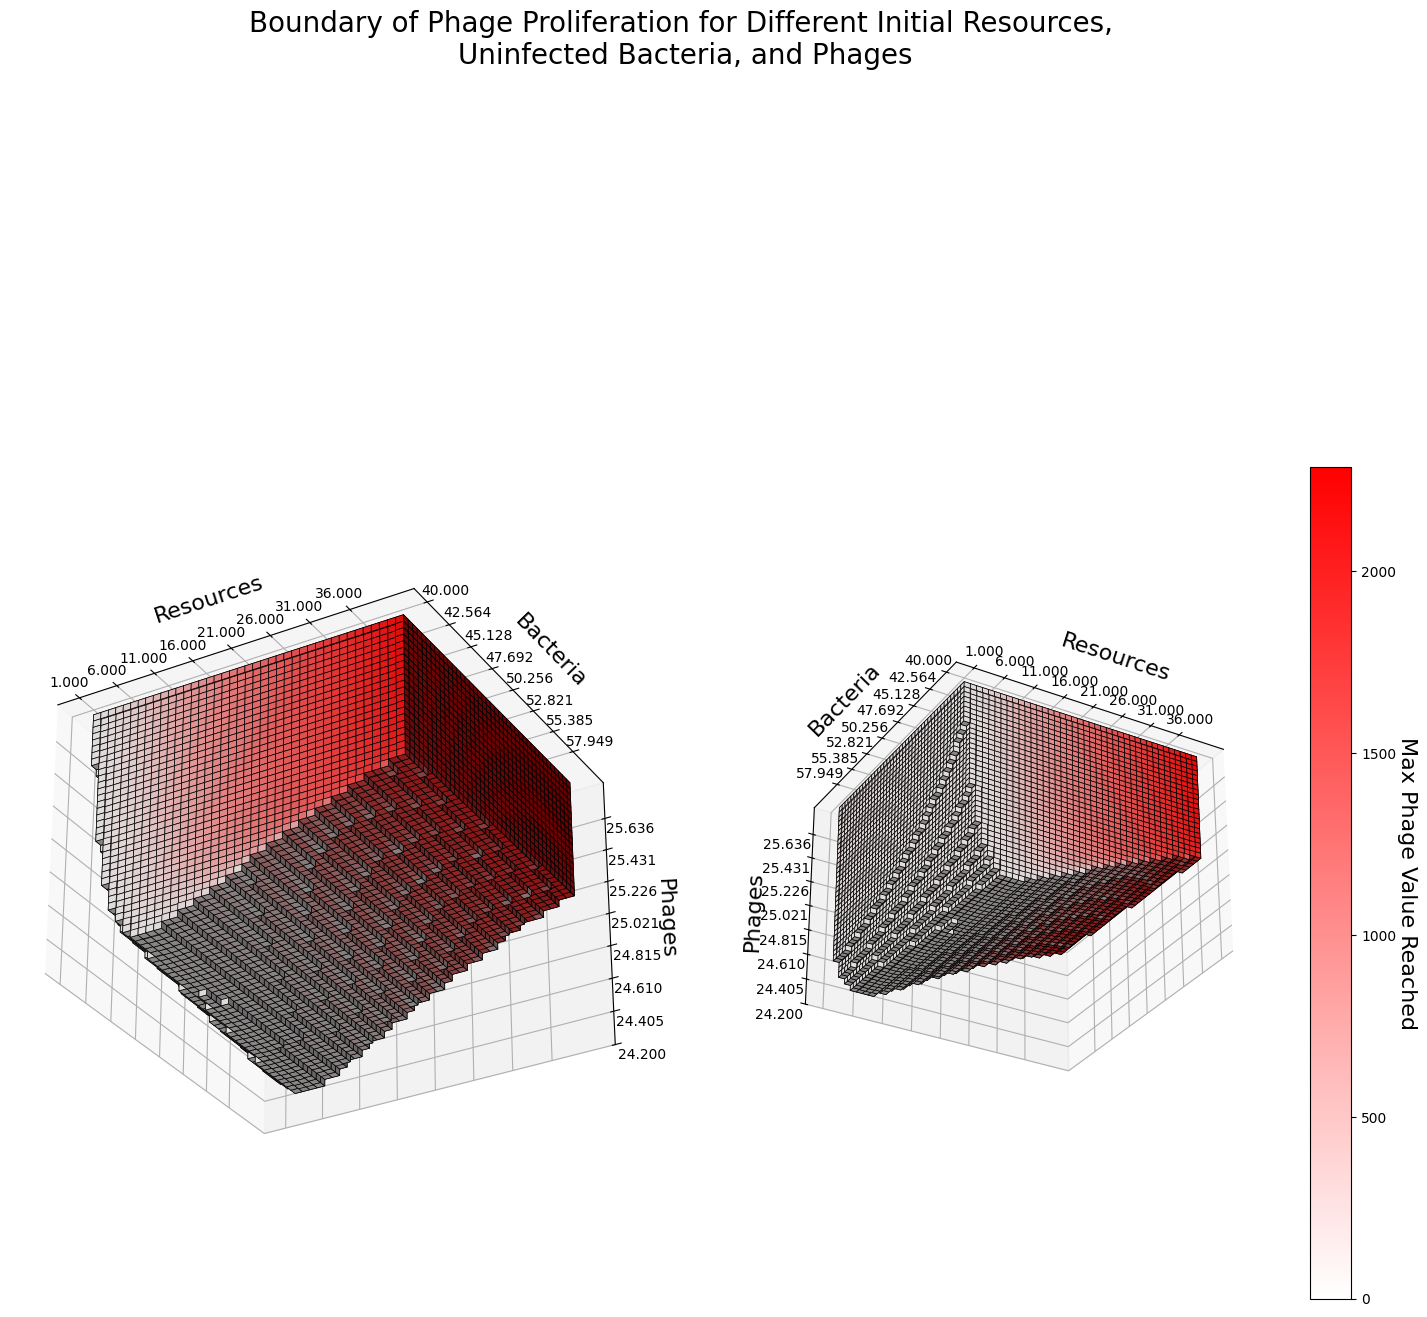

In [16]:
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

# matrix, matrix2 = analyze_matrix(pickle_data)
create_plot(len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2]), matrix, pickle_data, save_fig='3d_plot_resource_bacteria_phage.png'
)
